# Adversarial images and attacks with Keras and TensorFlow

In this tutorial, you will learn how to break deep learning models using image-based adversarial attacks. We will implement our adversarial attacks using the Keras and TensorFlow deep learning libraries.

<image src="images/basic_image_adversaries_header.png">

Imagine it’s twenty years from now. Nearly all cars and trucks on the road have been replaced with autonomous vehicles, powered by Artificial Intelligence, deep learning, and computer vision — every turn, lane switch, acceleration, and brake is powered by a deep neural network.

Now, imagine you’re on the highway. You’re sitting in the “driver’s seat” (is it really a “driver’s seat” if the car is doing the driving?) while your spouse is in the passenger seat, and your kids are in the back.

Looking ahead, you see a large sticker plastered on the lane your car is driving in. It looks innocent enough. It’s just a big print of the graffiti artist Banksy’s popular Girl with Balloon work. Some high school kids probably just put it there as part of a weird dare/practical joke

<image src="images/basic_image_adversaries_illustration.jpeg">

Figure 1: Performing an adversarial attack requires taking an input image (left), purposely perturbing it with a noise vector (middle), which forces the network to misclassify the input image, ultimately resulting in an incorrect classification, potentially with major consequences (right).

Adversarial images are:

1. Images that have pixels purposely and intentionally perturbed to confuse and deceive models …
2. … but at the same time, look harmless and innocent to humans.

While not an exact (or correct) comparison, I like to explain adversarial attacks in the context of image steganography. Using steganography algorithms, we can embed data (such as plaintext messages) in an image without distorting the appearance of the image itself. This image can be innocently transmitted to the receiver, who can then extract the hidden message from the image.



## What are adversarial images and adversarial attacks? And how to they impact deep learning models?

<image src="images/basic_image_adversaries_goodfellow.png">

Figure 2: When performing an adversarial attack, we present an input image (left) to our neural network. We then use gradient descent to construct the noise vector (middle). This noise vector is added to the input image, resulting in a misclassification (right). (Image source: Figure 1 of Explaining and Harnessing Adversarial Examples)

The classic example of an adversarial attack can be seen in Figure 2 above. On the left, we have our input image which our neural network correctly classifies as “panda” with 57.7% confidence.

In the middle, we have a noise vector, which to the human eye, appears to be random. However, it’s far from random.

Instead, the pixels in noise vector are “equal to the sign of the elements of the gradient of the cost function with the respect to the input image” (Goodfellow et al.).

We then add this noise vector to the input image, which produces the output (right) in Figure 2. To us, this image appears identical to the input; however, our neural network now classifies the image as a “gibbon” (a small ape, similar to a monkey) with 99.7% confidence.

## Import Packages

In [1]:
# import necessary packages
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications.resnet50 import decode_predictions
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import argparse
import imutils
import json
import cv2
import os

### Function to display images in Jupyter Notebooks and Google Colab

In [2]:
def plt_imshow(title, image):
    # convert the image frame BGR to RGB color space and display it
	plt.axis("off")
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.show()

### Our ImageNet class label/index helper utility

In [3]:
def get_class_idx(label):
	# build the path to the ImageNet class label mappings file
	labelPath = os.path.join("pyimagesearch","imagenet_class_index.json")

	# open the ImageNet class mappings file and load the mappings as
	# a dictionary with the human-readable class label as the key and
	# the integer index as the value
	with open(labelPath) as f:
		imageNetClasses = {labels[1]: int(idx) for (idx, labels) in json.load(f).items()}

	# check to see if the input class label has a corresponding
	# integer index value, and if so return it; otherwise return
	# a None-type value
	return imageNetClasses.get(label, None)

### Normal image classification WITHOUT adversarial attacks using Keras and TensorFlow

In [4]:
def preprocess_image(image):
	# swap color channels, preprocess the image, and add in a batch
	# dimension
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = preprocess_input(image)
	image = cv2.resize(image, (224, 224))
	image = np.expand_dims(image, axis=0)

	# return the preprocessed image
	return image

In [5]:
# construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", required=True,
# 	help="path to input image")
# args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"image": "data/pig.jpg"
}

In [6]:
# load image from disk and make a clone for annotation
print("[INFO] loading image...")
image = cv2.imread(args["image"])
output = image.copy()

# preprocess the input image
output = imutils.resize(output, width=400)
preprocessedImage = preprocess_image(image)

[INFO] loading image...


In [7]:
# load the pre-trained ResNet50 model
print("[INFO] loading pre-trained ResNet50 model...")
model = ResNet50(weights="imagenet")

# make predictions on the input image and parse the top-3 predictions
print("[INFO] making predictions...")
predictions = model.predict(preprocessedImage)
predictions = decode_predictions(predictions, top=3)[0]

[INFO] loading pre-trained ResNet50 model...
102973440/102967424 [==============================] - 1s 0us/step
[INFO] making predictions...
40960/35363 [==================================] - 0s 0us/step


In [9]:
# loop over the top three predictions
for (i, (imagenetID, label, prob)) in enumerate(predictions):
	# print the ImageNet class label ID of the top prediction to our
	# terminal (we'll need this label for our next script which will
	# perform the actual adversarial attack)
	if i == 0:
		print("[INFO] {} => {}".format(label, get_class_idx(label)))

	# display the prediction to our screen
	print("[INFO] {}. {}: {:.2f}%".format(i + 1, label, prob * 100))

[INFO] hog => 341
[INFO] 1. hog: 99.97%
[INFO] 2. wild_boar: 0.03%
[INFO] 3. piggy_bank: 0.00%


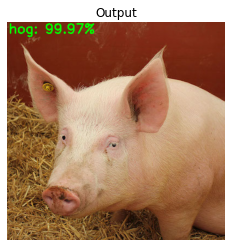

In [10]:
# draw the top-most predicted label on the image along with the
# confidence score
text = "{}: {:.2f}%".format(predictions[0][1], predictions[0][2] * 100)
cv2.putText(output, text, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.8,
	(0, 255, 0), 2)

# show the output image
plt_imshow("Output", output)

### Implementing adversarial images and attacks with Keras and TensorFlow

In [11]:
def preprocess_image(image):
	# swap color channels, resize the input image, and add a batch
	# dimension
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))
	image = np.expand_dims(image, axis=0)

	# return the preprocessed image
	return image

In [12]:
# This function will be used when we construct our perturbation vector, ensuring that the noise vector we construct falls within tolerable limits, and most importantly, does not significantly impact the visual quality of the output adversarial image.
# Keep in mind that adversarial images should be identical (to the human eye) to their original inputs — by clipping tensor values within tolerable limits, we are able to enforce this requirement.
def clip_eps(tensor, eps):
	# clip the values of the tensor to a given range [-eps, eps] and return it
	return tf.clip_by_value(tensor, clip_value_min=-eps, clip_value_max=eps)

The generate_adversaries method is the workhorse of our script. This function accepts four required parameters, including an optional fifth one:

* model: Our ResNet50 model (you could swap in a different pre-trained model such as VGG16, MobileNet, etc. if you prefer).
* baseImage: The original non-perturbed input image that we wish to construct an adversarial attack for, causing our model to misclassify it.
* delta: Our noise vector, which will be added to the baseImage , ultimately causing the misclassification. We’ll update this delta vector by means of gradient descent.
* classIdx: The integer class label index we obtained by running the predict_normal.py script.
* steps: Number of gradient descent steps to perform (defaults to 50 steps).

In [13]:
def generate_adversaries(model, baseImage, delta, classIdx, steps=50):
	# iterate over the number of steps
	for step in range(0, steps):
		# record our gradients
		with tf.GradientTape() as tape:
			# explicitly indicate that our perturbation vector should
			# be tracked for gradient updates
			tape.watch(delta)

			# add our perturbation vector to the base image and
			# preprocess the resulting image
			adversary = preprocess_input(baseImage + delta)

			# run this newly constructed image tensor through our
			# model and calculate the loss with respect to the
			# *original* class index
			predictions = model(adversary, training=False)
			loss = -sccLoss(tf.convert_to_tensor([classIdx]),
				predictions)

			# check to see if we are logging the loss value, and if
			# so, display it to our terminal
			if step % 5 == 0:
				print("step: {}, loss: {}...".format(step, loss.numpy()))

		# calculate the gradients of loss with respect to the
		# perturbation vector
		gradients = tape.gradient(loss, delta)

		# update the weights, clip the perturbation vector, and
		# update its value
		optimizer.apply_gradients([(gradients, delta)])
		delta.assign_add(clip_eps(delta, eps=EPS))

	# return the perturbation vector
	return delta

In [14]:
# construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--input", required=True,
# 	help="path to original input image")
# ap.add_argument("-o", "--output", required=True,
# 	help="path to output adversarial image")
# ap.add_argument("-c", "--class-idx", type=int, required=True,
# 	help="ImageNet class ID of the predicted label")
# args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"input": "data/pig.jpg",
    "output": "data/adversarial.png",
    "class_idx": 341
}

In [15]:
# define the epsilon and learning rate constants
EPS = 2 / 255.0
LR = 0.1

In [16]:
# load the input image from disk and preprocess it
print("[INFO] loading image...")
image = cv2.imread(args["input"])
image = preprocess_image(image)

[INFO] loading image...


In [17]:
# load the pre-trained ResNet50 model for running inference
print("[INFO] loading pre-trained ResNet50 model...")
model = ResNet50(weights="imagenet")

# initialize optimizer and loss function
optimizer = Adam(learning_rate=LR)
sccLoss = SparseCategoricalCrossentropy()

[INFO] loading pre-trained ResNet50 model...


In [18]:
# create a tensor based off of the input image and initialize the
# perturbation vector (we will update this vector via training)
baseImage = tf.constant(image, dtype=tf.float32)
delta = tf.Variable(tf.zeros_like(baseImage), trainable=True)

# generate the perturbation vector to create an adversarial example
print("[INFO] generating perturbation...")
deltaUpdated = generate_adversaries(model, baseImage, delta, args["class_idx"])

# create the adversarial example, swap color channels, and save the
# output image to disk
print("[INFO] creating adversarial example...")
adverImage = (baseImage + deltaUpdated).numpy().squeeze()
adverImage = np.clip(adverImage, 0, 255).astype("uint8")
adverImage = cv2.cvtColor(adverImage, cv2.COLOR_RGB2BGR)
cv2.imwrite(args["output"], adverImage)

[INFO] generating perturbation...
step: 0, loss: -0.00031132620642893016...
step: 5, loss: -0.0009657248156145215...
step: 10, loss: -0.005241462029516697...
step: 15, loss: -0.06326662003993988...
step: 20, loss: -0.7704905271530151...
step: 25, loss: -3.46222186088562...
step: 30, loss: -7.560562610626221...
step: 35, loss: -13.632922172546387...
step: 40, loss: -22.212743759155273...
step: 45, loss: -31.67696189880371...
[INFO] creating adversarial example...


True

[INFO] running inference on the adversarial example...
[INFO] label: wombat confidence: 100.00%


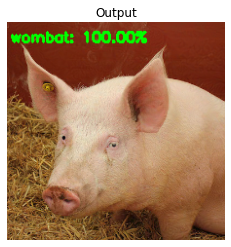

In [19]:
# run inference with this adversarial example, parse the results,
# and display the top-1 predicted result
print("[INFO] running inference on the adversarial example...")
preprocessedImage = preprocess_input(baseImage + deltaUpdated)
predictions = model.predict(preprocessedImage)
predictions = decode_predictions(predictions, top=3)[0]
label = predictions[0][1]
confidence = predictions[0][2] * 100
print("[INFO] label: {} confidence: {:.2f}%".format(label,
	confidence))

# draw the top-most predicted label on the adversarial image along
# with the confidence score
text = "{}: {:.2f}%".format(label, confidence)
cv2.putText(adverImage, text, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
	(0, 255, 0), 2)

# show the output image
plt_imshow("Output", adverImage)

### Targeted adversarial attacks with Keras and TensorFlow

### Implementing targeted adversarial attacks with Keras and TensorFlow

In [20]:
def generate_targeted_adversaries(model, baseImage, delta, classIdx,
	target, steps=500):
	# iterate over the number of steps
	for step in range(0, steps):
		# record our gradients
		with tf.GradientTape() as tape:
			# explicitly indicate that our perturbation vector should
			# be tracked for gradient updates
			tape.watch(delta)

			# add our perturbation vector to the base image and
			# preprocess the resulting image
			adversary = preprocess_input(baseImage + delta)

			# run this newly constructed image tensor through our
			# model and calculate the loss with respect to the
			# both the *original* class label and the *target*
			# class label
			predictions = model(adversary, training=False)
			originalLoss = -sccLoss(tf.convert_to_tensor([classIdx]),
				predictions)
			targetLoss = sccLoss(tf.convert_to_tensor([target]),
				predictions)
			totalLoss = originalLoss + targetLoss

			# check to see if we are logging the loss value, and if
			# so, display it to our terminal
			if step % 20 == 0:
				print("step: {}, loss: {}...".format(step,
					totalLoss.numpy()))

		# calculate the gradients of loss with respect to the
		# perturbation vector
		gradients = tape.gradient(totalLoss, delta)

		# update the weights, clip the perturbation vector, and
		# update its value
		optimizer.apply_gradients([(gradients, delta)])
		delta.assign_add(clip_eps(delta, eps=EPS))

	# return the perturbation vector
	return delta

originalLoss = -sccLoss

targetLoss = sccLoss

=> We take the negative/positive signs that way because our objective is **to minimize the probability for the true class and maximize the probability of the target class**.

In [21]:
# construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--input", required=True,
# 	help="path to original input image")
# ap.add_argument("-o", "--output", required=True,
# 	help="path to output adversarial image")
# ap.add_argument("-c", "--class-idx", type=int, required=True,
# 	help="ImageNet class ID of the predicted label")
# ap.add_argument("-t", "--target-class-idx", type=int, required=True,
# 	help="ImageNet class ID of the target adversarial label")
# args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"input": "data/pig.jpg",
    "output": "output/adversarial.png",
    "class_idx": 341,
    "target_class_idx": 189
}

In [22]:
# define the epsilon and learning rate constants
EPS = 2 / 255.0
LR = 5e-3

In [23]:
# load image from disk and preprocess it
print("[INFO] loading image...")
image = cv2.imread(args["input"])
image = preprocess_image(image)

[INFO] loading image...


In [24]:
# load the pre-trained ResNet50 model for running inference
print("[INFO] loading pre-trained ResNet50 model...")
model = ResNet50(weights="imagenet")

# initialize optimizer and loss function
optimizer = Adam(learning_rate=LR)
sccLoss = SparseCategoricalCrossentropy()

[INFO] loading pre-trained ResNet50 model...


In [25]:
# create a tensor based off of the input image and initialize the
# perturbation vector (we will update this vector via training)
baseImage = tf.constant(image, dtype=tf.float32)
delta = tf.Variable(tf.zeros_like(baseImage), trainable=True)

# generate the perturbation vector to create an adversarial example
print("[INFO] generating perturbation...")
deltaUpdated = generate_targeted_adversaries(model, baseImage, delta,
	args["class_idx"], args["target_class_idx"])

# create the adversarial example, swap color channels, and save the
# output image to disk
print("[INFO] creating targeted adversarial example...")
adverImage = (baseImage + deltaUpdated).numpy().squeeze()
adverImage = np.clip(adverImage, 0, 255).astype("uint8")
adverImage = cv2.cvtColor(adverImage, cv2.COLOR_RGB2BGR)
cv2.imwrite(args["output"], adverImage)

[INFO] generating perturbation...
step: 0, loss: 27.602771759033203...
step: 20, loss: 18.396570205688477...
step: 40, loss: 13.426019668579102...
step: 60, loss: 10.25888442993164...
step: 80, loss: 7.851416110992432...
step: 100, loss: 6.063114166259766...
step: 120, loss: 4.63791561126709...
step: 140, loss: 3.4332144260406494...
step: 160, loss: 2.409649610519409...
step: 180, loss: 1.4420342445373535...
step: 200, loss: 0.5055522918701172...
step: 220, loss: -0.4226346015930176...
step: 240, loss: -1.2374377250671387...
step: 260, loss: -2.0204365253448486...
step: 280, loss: -2.7935385704040527...
step: 300, loss: -3.486555814743042...
step: 320, loss: -4.118650913238525...
step: 340, loss: -4.726422309875488...
step: 360, loss: -5.326793670654297...
step: 380, loss: -5.948738098144531...
step: 400, loss: -6.607177257537842...
step: 420, loss: -7.297648906707764...
step: 440, loss: -8.01059627532959...
step: 460, loss: -8.718798637390137...
step: 480, loss: -9.463754653930664...


False

[INFO] running inference on the adversarial example...
[INFO] label: Lakeland_terrier confidence: 71.06%


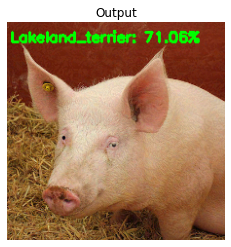

In [26]:
# run inference with this adversarial example, parse the results,
# and display the top-1 predicted result
print("[INFO] running inference on the adversarial example...")
preprocessedImage = preprocess_input(baseImage + deltaUpdated)
predictions = model.predict(preprocessedImage)
predictions = decode_predictions(predictions, top=3)[0]
label = predictions[0][1]
confidence = predictions[0][2] * 100
print("[INFO] label: {} confidence: {:.2f}%".format(label, confidence))

# draw the top-most predicted label on the adversarial image along
# with the confidence score
text = "{}: {:.2f}%".format(label, confidence)
cv2.putText(adverImage, text, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
	(0, 255, 0), 2)

# show the output image
plt_imshow("Output", adverImage)

## Adversarial attacks with FGSM (Fast Gradient Sign Method)

Quoting the TensorFlow documentation on FGSM, we can express the Fast Gradient Sign Method using the following equation:

<image src="images/fgsm_equation.png">

Figure 2: The Fast Gradient Sign Method expressed mathematically (image source).
where:

* ${adv}\_x$: Our output adversarial image
* x: The original input image
* y: The ground-truth label of the input image
* $\epsilon$: Small value we multiply the signed gradients by to ensure the perturbations are small enough that the human eye cannot detect them but large enough that they fool the neural network
* $\theta$: Our neural network model
* J: The loss function

### Import Packages

In [27]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MSE
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2

### Creating a simple CNN architecture for adversarial training

In [28]:
class SimpleCNN:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

		# first CONV => RELU => BN layer set
		model.add(Conv2D(32, (3, 3), strides=(2, 2), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))

		# second CONV => RELU => BN layer set
		model.add(Conv2D(64, (3, 3), strides=(2, 2), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))

		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(128))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

### Implementing the Fast Gradient Sign Method with Keras and TensorFlow

In [29]:
def generate_image_adversary(model, image, label, eps=2 / 255.0):
	# cast the image
	image = tf.cast(image, tf.float32)

	# record our gradients
	with tf.GradientTape() as tape:
		# explicitly indicate that our image should be tacked for
		# gradient updates
		tape.watch(image)

		# use our model to make predictions on the input image and
		# then compute the loss
		pred = model(image)
		loss = MSE(label, pred)

	# calculate the gradients of loss with respect to the image, then
	# compute the sign of the gradient
	gradient = tape.gradient(loss, image)
	signedGrad = tf.sign(gradient) # = [1 (positive), 0, or -1 (negative)]

	# construct the image adversary
	adversary = (image + (signedGrad * eps)).numpy()

	# return the image adversary to the calling function
	return adversary

### Creating our adversarial training script

In [30]:
# load MNIST dataset and scale the pixel values to the range [0, 1]
print("[INFO] loading MNIST dataset...")
(trainX, trainY), (testX, testY) = mnist.load_data()
trainX = trainX / 255.0
testX = testX / 255.0

# add a channel dimension to the images
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)

# one-hot encode our labels
trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

[INFO] loading MNIST dataset...
11493376/11490434 [==============================] - 0s 0us/step


In [31]:
# initialize our optimizer and model
print("[INFO] compiling model...")
opt = Adam(lr=1e-3)
model = SimpleCNN.build(width=28, height=28, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the simple CNN on MNIST
print("[INFO] training network...")
model.fit(trainX, trainY,
	validation_data=(testX, testY),
	batch_size=64,
	epochs=10,
	verbose=1)

# make predictions on the testing set for the model trained on
# non-adversarial images
(loss, acc) = model.evaluate(x=testX, y=testY, verbose=0)
print("[INFO] loss: {:.4f}, acc: {:.4f}".format(loss, acc))

[INFO] compiling model...
[INFO] training network...
Epoch 1/10
938/938 [==============================] - 4s 4ms/step - loss: 0.3824 - accuracy: 0.8855 - val_loss: 0.0556 - val_accuracy: 0.9823
Epoch 2/10
938/938 [==============================] - 3s 4ms/step - loss: 0.0786 - accuracy: 0.9759 - val_loss: 0.0464 - val_accuracy: 0.9852
Epoch 3/10
938/938 [==============================] - 3s 4ms/step - loss: 0.0585 - accuracy: 0.9816 - val_loss: 0.0401 - val_accuracy: 0.9865
Epoch 4/10
938/938 [==============================] - 3s 4ms/step - loss: 0.0490 - accuracy: 0.9845 - val_loss: 0.0395 - val_accuracy: 0.9867
Epoch 5/10
938/938 [==============================] - 3s 4ms/step - loss: 0.0358 - accuracy: 0.9885 - val_loss: 0.0370 - val_accuracy: 0.9877
Epoch 6/10
938/938 [==============================] - 3s 4ms/step - loss: 0.0348 - accuracy: 0.9889 - val_loss: 0.0389 - val_accuracy: 0.9878
Epoch 7/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0267 - accuracy: 0.

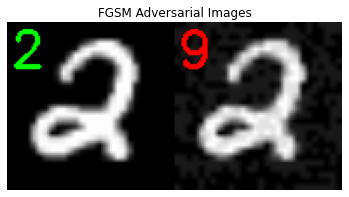

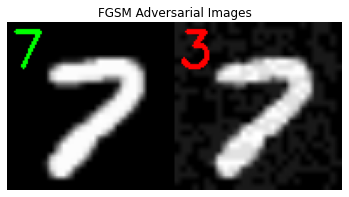

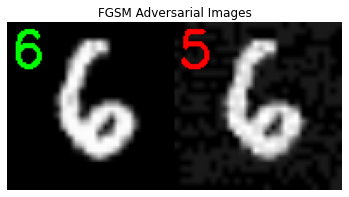

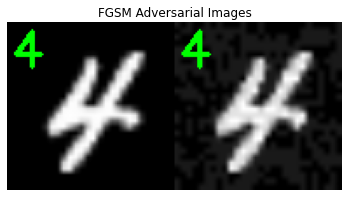

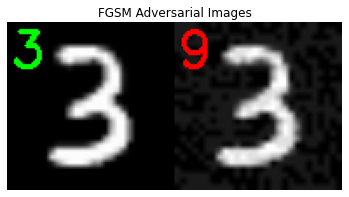

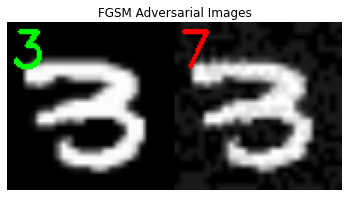

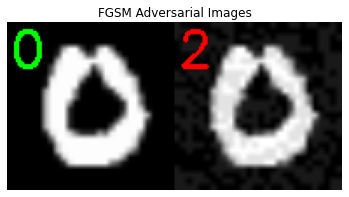

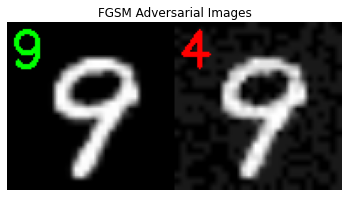

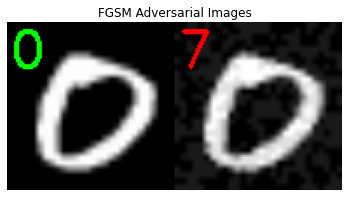

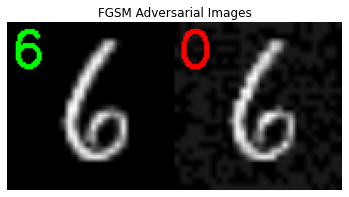

In [32]:
# loop over a sample of our testing images
for i in np.random.choice(np.arange(0, len(testX)), size=(10,)):
	# grab the current image and label
	image = testX[i]
	label = testY[i]

	# generate an image adversary for the current image and make
	# a prediction on the adversary
    # image.reshape(1, 28, 28, 1) = 1 Batch dimension, 28x28x1
	adversary = generate_image_adversary(model, image.reshape(1, 28, 28, 1), label, eps=0.1)
	pred = model.predict(adversary)

	# Prepare the image and adversary for visualization
    # scale both the original image and adversary to the range
	# [0, 255] and convert them to an unsigned 8-bit integers
	adversary = adversary.reshape((28, 28)) * 255
	adversary = np.clip(adversary, 0, 255).astype("uint8")
	image = image.reshape((28, 28)) * 255
	image = image.astype("uint8")

	# convert the image and adversarial image from grayscale to three
	# channel (so we can draw on them)
	image = np.dstack([image] * 3)
	adversary = np.dstack([adversary] * 3)

	# resize the images so we can better visualize them
	image = cv2.resize(image, (96, 96))
	adversary = cv2.resize(adversary, (96, 96))

	# Visualization process
    # determine the predicted label for both the original image and
	# adversarial image
	imagePred = label.argmax()
	adversaryPred = pred[0].argmax()
	color = (0, 255, 0)

	# if the image prediction does not match the adversarial
	# prediction then update the color
	if imagePred != adversaryPred:
		color = (0, 0, 255)

	# draw the predictions on the respective output images
	cv2.putText(image, str(imagePred), (2, 25),
		cv2.FONT_HERSHEY_SIMPLEX, 0.95, (0, 255, 0), 2)
	cv2.putText(adversary, str(adversaryPred), (2, 25),
		cv2.FONT_HERSHEY_SIMPLEX, 0.95, color, 2)

	# stack the two images horizontally and then show the original
	# image and adversarial image
	output = np.hstack([image, adversary])
	plt_imshow("FGSM Adversarial Images", output)

# Defending against adversarial image attacks with Keras and TensorFlow

One of the easiest ways to defend against adversarial attacks is to train your model on these types of images.

For example, if we are worried nefarious users applying FGSM attacks to our model, then we can “inoculate” our neural network by training them on FSGM images of our own.

Typically, this type of adversarial inoculation is applied by either:

1. Training our model on a given dataset, generating a set of adversarial images, and then fine-tuning the model on the adversarial images
2. Generating mixed batches of both the original training images and adversarial images, followed by fine-tuning our neural network on these mixed batches

## Problems and considerations with adversarial image defense
Both of the adversarial image defense methods mentioned in the previous section are dependent on:

1. The model architecture and weights used to generate the adversarial examples
2. The optimizer used to generate them

These training schemes might not generalize well if we simply create an adversarial image with a different model (potentially a more complex one).

Additionally, if we train only on adversarial images then the model might not perform well on the regular images. This phenomenon is often referred to as catastrophic forgetting, and in the context of adversarial defense, means that the model has “forgotten” what a real image looks like.

To mitigate this problem, we first generate a set of adversarial images, mix them with the regular training set, and then finally train the model (which we will do in next week’s blog post).

### Import Packages

In [33]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MSE
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2

### Implementing a custom data generator used to generate adversarial images during training

In [34]:
def generate_adversarial_batch(model, total, images, labels, dims, eps=0.01):
	# unpack the image dimensions into convenience variables
	(h, w, c) = dims

	# we're constructing a data generator here so we need to loop
	# indefinitely
	while True:
		# initialize our perturbed images and labels
		perturbImages = []
		perturbLabels = []

		# randomly sample indexes (without replacement) from the
		# input data
		idxs = np.random.choice(range(0, len(images)), size=total, replace=False)

		# loop over the indexes
		for i in idxs:
			# grab the current image and label
			image = images[i]
			label = labels[i]

			# generate an adversarial image
			adversary = generate_image_adversary(model,
				image.reshape(1, h, w, c), label, eps=eps)

			# update our perturbed images and labels lists
			perturbImages.append(adversary.reshape(h, w, c))
			perturbLabels.append(label)

		# yield the perturbed images and labels
		yield (np.array(perturbImages), np.array(perturbLabels))

### Training on normal images, fine-tuning on adversarial images

In [35]:
# load MNIST dataset and scale the pixel values to the range [0, 1]
print("[INFO] loading MNIST dataset...")
(trainX, trainY), (testX, testY) = mnist.load_data()
trainX = trainX / 255.0
testX = testX / 255.0

# add a channel dimension to the images
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)

# one-hot encode our labels
trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

[INFO] loading MNIST dataset...


In [36]:
# initialize our optimizer and model
print("[INFO] compiling model...")
opt = Adam(lr=1e-3)
model = SimpleCNN.build(width=28, height=28, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the simple CNN on MNIST
print("[INFO] training network...")
model.fit(trainX, trainY,
	validation_data=(testX, testY),
	batch_size=64,
	epochs=20,
	verbose=1)

[INFO] compiling model...
[INFO] training network...
Epoch 1/20
938/938 [==============================] - 4s 4ms/step - loss: 0.3730 - accuracy: 0.8889 - val_loss: 0.0582 - val_accuracy: 0.9811
Epoch 2/20
938/938 [==============================] - 3s 4ms/step - loss: 0.0784 - accuracy: 0.9764 - val_loss: 0.0466 - val_accuracy: 0.9850
Epoch 3/20
938/938 [==============================] - 3s 4ms/step - loss: 0.0583 - accuracy: 0.9824 - val_loss: 0.0378 - val_accuracy: 0.9868
Epoch 4/20
938/938 [==============================] - 3s 4ms/step - loss: 0.0465 - accuracy: 0.9854 - val_loss: 0.0373 - val_accuracy: 0.9864
Epoch 5/20
938/938 [==============================] - 3s 4ms/step - loss: 0.0411 - accuracy: 0.9875 - val_loss: 0.0367 - val_accuracy: 0.9869
Epoch 6/20
938/938 [==============================] - 3s 4ms/step - loss: 0.0306 - accuracy: 0.9903 - val_loss: 0.0337 - val_accuracy: 0.9893
Epoch 7/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0308 - accuracy: 0.

In [37]:
# make predictions on the testing set for the model trained on
# non-adversarial images
(loss, acc) = model.evaluate(x=testX, y=testY, verbose=0)
print("[INFO] normal testing images:")
print("[INFO] loss: {:.4f}, acc: {:.4f}\n".format(loss, acc))

# generate a set of adversarial from our test set
print("[INFO] generating adversarial examples with FGSM...\n")
(advX, advY) = next(generate_adversarial_batch(model, len(testX),
	testX, testY, (28, 28, 1), eps=0.1))

# re-evaluate the model on the adversarial images
(loss, acc) = model.evaluate(x=advX, y=advY, verbose=0)
print("[INFO] adversarial testing images:")
print("[INFO] loss: {:.4f}, acc: {:.4f}\n".format(loss, acc))

[INFO] normal testing images:
[INFO] loss: 0.0461, acc: 0.9879

[INFO] generating adversarial examples with FGSM...

[INFO] adversarial testing images:
[INFO] loss: 16.1901, acc: 0.0069



In [38]:
# lower the learning rate and re-compile the model (such that we can
# find tune it on the adversarial images)
print("[INFO] re-compiling model...")
opt = Adam(lr=1e-4)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# fine-tune our CNN on the adversarial images
print("[INFO] fine-tuning network on adversarial examples...")
model.fit(advX, advY,
	batch_size=64,
	epochs=10,
	verbose=1)

[INFO] re-compiling model...
[INFO] fine-tuning network on adversarial examples...
Epoch 1/10
157/157 [==============================] - 1s 3ms/step - loss: 11.6266 - accuracy: 0.1124
Epoch 2/10
157/157 [==============================] - 1s 3ms/step - loss: 3.7337 - accuracy: 0.5312
Epoch 3/10
157/157 [==============================] - 1s 3ms/step - loss: 1.6567 - accuracy: 0.7367
Epoch 4/10
157/157 [==============================] - 1s 4ms/step - loss: 0.9861 - accuracy: 0.8296
Epoch 5/10
157/157 [==============================] - 1s 3ms/step - loss: 0.6239 - accuracy: 0.8810
Epoch 6/10
157/157 [==============================] - 1s 3ms/step - loss: 0.3664 - accuracy: 0.9245
Epoch 7/10
157/157 [==============================] - 1s 3ms/step - loss: 0.2886 - accuracy: 0.9366
Epoch 8/10
157/157 [==============================] - 1s 3ms/step - loss: 0.2167 - accuracy: 0.9487
Epoch 9/10
157/157 [==============================] - 1s 3ms/step - loss: 0.1788 - accuracy: 0.9589
Epoch 10/10
157/

In [39]:
# now that our model is fine-tuned we should evaluate it on the test
# set (i.e., non-adversarial) again to see if performance has degraded
(loss, acc) = model.evaluate(x=testX, y=testY, verbose=0)
print("")
print("[INFO] normal testing images *after* fine-tuning:")
print("[INFO] loss: {:.4f}, acc: {:.4f}\n".format(loss, acc))

# do a final evaluation of the model on the adversarial images
(loss, acc) = model.evaluate(x=advX, y=advY, verbose=0)
print("[INFO] adversarial images *after* fine-tuning:")
print("[INFO] loss: {:.4f}, acc: {:.4f}".format(loss, acc))


[INFO] normal testing images *after* fine-tuning:
[INFO] loss: 0.0557, acc: 0.9839

[INFO] adversarial images *after* fine-tuning:
[INFO] loss: 0.0687, acc: 0.9806


# Mixing normal images and adversarial images when training CNNs

We can modify this standard training procedure to incorporate adversarial examples by:

1. Initializing our neural network
2. Selecting a total of N training examples
3. Use the model and a method like FGSM to generate a total of N adversarial examples as well
4. Combine the two sets, forming a batch of size Nx2
5. Train the model on both the adversarial examples and original training samples

<image src="images/mixed_normal_adversary_step4.png">


In [40]:
from sklearn.utils import shuffle

### Updating our data generator to mix normal images with adversarial images on the fly

In [41]:
def generate_mixed_adverserial_batch(model, total, images, labels,
	dims, eps=0.01, split=0.5):
	# unpack the image dimensions into convenience variables
	(h, w, c) = dims

	# compute the total number of training images to keep along with
	# the number of adversarial images to generate
	totalNormal = int(total * split)
	totalAdv = int(total * (1 - split))

	# we're constructing a data generator so we need to loop
	# indefinitely
	while True:
		# randomly sample indexes (without replacement) from the
		# input data and then use those indexes to sample our normal
		# images and labels
		idxs = np.random.choice(range(0, len(images)),
			size=totalNormal, replace=False)
		mixedImages = images[idxs]
		mixedLabels = labels[idxs]

		# again, randomly sample indexes from the input data, this
		# time to construct our adversarial images
		idxs = np.random.choice(range(0, len(images)), size=totalAdv,
			replace=False)

		# loop over the indexes
		for i in idxs:
			# grab the current image and label, then use that data to
			# generate the adversarial example
			image = images[i]
			label = labels[i]
			adversary = generate_image_adversary(model,
				image.reshape(1, h, w, c), label, eps=eps)

			# update the mixed images and labels lists
			mixedImages = np.vstack([mixedImages, adversary])
			mixedLabels = np.vstack([mixedLabels, label])

		# shuffle the images and labels together
		(mixedImages, mixedLabels) = shuffle(mixedImages, mixedLabels)

		# yield the mixed images and labels to the calling function
		yield (mixedImages, mixedLabels)

### Creating our mixed image and adversarial image training script

In [42]:
# load MNIST dataset and scale the pixel values to the range [0, 1]
print("[INFO] loading MNIST dataset...")
(trainX, trainY), (testX, testY) = mnist.load_data()
trainX = trainX / 255.0
testX = testX / 255.0

# add a channel dimension to the images
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)

# one-hot encode our labels
trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

[INFO] loading MNIST dataset...


In [43]:
# initialize our optimizer and model
print("[INFO] compiling model...")
opt = Adam(lr=1e-3)
model = SimpleCNN.build(width=28, height=28, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the simple CNN on MNIST
print("[INFO] training network...")
model.fit(trainX, trainY,
	validation_data=(testX, testY),
	batch_size=64,
	epochs=20,
	verbose=1)

[INFO] compiling model...
[INFO] training network...
Epoch 1/20
938/938 [==============================] - 4s 4ms/step - loss: 0.3766 - accuracy: 0.8868 - val_loss: 0.0569 - val_accuracy: 0.9811
Epoch 2/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0767 - accuracy: 0.9760 - val_loss: 0.0475 - val_accuracy: 0.9858
Epoch 3/20
938/938 [==============================] - 3s 4ms/step - loss: 0.0540 - accuracy: 0.9836 - val_loss: 0.0364 - val_accuracy: 0.9869
Epoch 4/20
938/938 [==============================] - 3s 4ms/step - loss: 0.0464 - accuracy: 0.9859 - val_loss: 0.0438 - val_accuracy: 0.9873
Epoch 5/20
938/938 [==============================] - 3s 4ms/step - loss: 0.0377 - accuracy: 0.9879 - val_loss: 0.0390 - val_accuracy: 0.9866
Epoch 6/20
938/938 [==============================] - 3s 4ms/step - loss: 0.0333 - accuracy: 0.9891 - val_loss: 0.0386 - val_accuracy: 0.9877
Epoch 7/20
938/938 [==============================] - 3s 4ms/step - loss: 0.0273 - accuracy: 0.

In [44]:
# make predictions on the testing set for the model trained on
# non-adversarial images
(loss, acc) = model.evaluate(x=testX, y=testY, verbose=0)
print("[INFO] normal testing images:")
print("[INFO] loss: {:.4f}, acc: {:.4f}\n".format(loss, acc))

# generate a set of adversarial from our test set (so we can evaluate
# our model performance *before* and *after* mixed adversarial
# training)
print("[INFO] generating adversarial examples with FGSM...\n")
(advX, advY) = next(generate_adversarial_batch(model, len(testX),
	testX, testY, (28, 28, 1), eps=0.1))

# re-evaluate the model on the adversarial images
(loss, acc) = model.evaluate(x=advX, y=advY, verbose=0)
print("[INFO] adversarial testing images:")
print("[INFO] loss: {:.4f}, acc: {:.4f}\n".format(loss, acc))

[INFO] normal testing images:
[INFO] loss: 0.0364, acc: 0.9917

[INFO] generating adversarial examples with FGSM...

[INFO] adversarial testing images:
[INFO] loss: 12.1203, acc: 0.0317



In [45]:
# lower the learning rate and re-compile the model (such that we can
# fine-tune it on the mixed batches of normal images and dynamically
# generated adversarial images)
print("[INFO] re-compiling model...")
opt = Adam(lr=1e-4)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# initialize our data generator to create data batches containing
# a mix of both *normal* images and *adversarial* images
print("[INFO] creating mixed data generator...")
dataGen = generate_mixed_adverserial_batch(model, 64,
	trainX, trainY, (28, 28, 1), eps=0.1, split=0.5)

# fine-tune our CNN on the adversarial images
print("[INFO] fine-tuning network on dynamic mixed data...")
model.fit(
	dataGen,
	steps_per_epoch=len(trainX) // 64,
	epochs=10,
	verbose=1)

[INFO] re-compiling model...
[INFO] creating mixed data generator...
[INFO] fine-tuning network on dynamic mixed data...
Epoch 1/10
937/937 [==============================] - 247s 263ms/step - loss: 2.8447 - accuracy: 0.6578
Epoch 2/10
937/937 [==============================] - 246s 263ms/step - loss: 0.4907 - accuracy: 0.8643
Epoch 3/10
937/937 [==============================] - 246s 263ms/step - loss: 0.3565 - accuracy: 0.8941
Epoch 4/10
937/937 [==============================] - 246s 263ms/step - loss: 0.2806 - accuracy: 0.9106
Epoch 5/10
937/937 [==============================] - 245s 262ms/step - loss: 0.2304 - accuracy: 0.9278
Epoch 6/10
937/937 [==============================] - 245s 261ms/step - loss: 0.1846 - accuracy: 0.9407
Epoch 7/10
937/937 [==============================] - 245s 261ms/step - loss: 0.1639 - accuracy: 0.9471
Epoch 8/10
937/937 [==============================] - 244s 261ms/step - loss: 0.1491 - accuracy: 0.9533
Epoch 9/10
937/937 [===========================

In [46]:
# now that our model is fine-tuned we should evaluate it on the test
# set (i.e., non-adversarial) again to see if performance has degraded
(loss, acc) = model.evaluate(x=testX, y=testY, verbose=0)
print("")
print("[INFO] normal testing images *after* fine-tuning:")
print("[INFO] loss: {:.4f}, acc: {:.4f}\n".format(loss, acc))

# do a final evaluation of the model on the adversarial images
(loss, acc) = model.evaluate(x=advX, y=advY, verbose=0)
print("[INFO] adversarial images *after* fine-tuning:")
print("[INFO] loss: {:.4f}, acc: {:.4f}".format(loss, acc))


[INFO] normal testing images *after* fine-tuning:
[INFO] loss: 0.0298, acc: 0.9911

[INFO] adversarial images *after* fine-tuning:
[INFO] loss: 0.1086, acc: 0.9646
